In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
import pickle
from keras.models import Model
#from keras.layers import Conv2D
import os
from keras.applications.vgg16 import VGG16

In [2]:
print(os.listdir())

['res34_backbone_50epochs.hdf5', 'images', 'vgg19_backbone_50epochs.hdf5', 'Improved_UNet_Via_Ensembles.ipynb', 'main.py', 'history_unet_50epochs.csv', 'simple_multi_unet_model.py', 'LinkNetvsUNet2.ipynb', '__pycache__', 'unet.ipynb', 'tiff_to_jpeg.py', 'image_segmentation.py', 'LinkNetvsUNet1.ipynb', 'inceptionv3_backbone_50epochs.hdf5', 'model_XG.sav', 'binary_unet_model.ipynb', 'lgbm.ipynb', 'unet_using_vgg_resnet_inception.ipynb', 'crop_image.py', 'tiff_to_jpeg.ipynb', '.ipynb_checkpoints', 'links.txt', 'segmentation_models.ipynb', 'linknet_res34_backbone_50epochs.hdf5', 'random_forest.ipynb', 'simple_unet_model.py', 'test.hdf5', '1.Data_Preprocessing', 'AnnotatedImages', 'RF_model.sav', 'image_screenshot_12.08.2024.png', '.idea', 'cell_500_epochs_catXentropy_acc_with_weights.hdf5', 'xgboost_model.ipynb', 'sandstone_50_epochs_catXentropy_acc_with_weights.hdf5', 'unet_res34_backbone_50epochs.hdf5', 'cell_50_epochs_catXentropy_acc_with_weights.hdf5', '.gitignore', 'Preprocessing.ipyn

In [3]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128

#Capture training image info as a list
train_images = []

In [4]:
for directory_path in glob.glob("images/original_images"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)  
        #print(img.shape)
        img = cv2.resize(img, (SIZE_X, SIZE_Y))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing        
train_images = np.array(train_images)

In [5]:
#Capture mask/label info as a list
train_masks = [] 
for directory_path in glob.glob("images/masked_images"):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [6]:
train_images[0].shape

(128, 128, 3)

In [7]:
train_masks[0].shape

(128, 128)

In [8]:
#Use customary x_train and y_train variables
X_train = train_images
y_train = train_masks
y_train = np.expand_dims(y_train, axis=3) #May not be necessary.. leftover from previous code 

In [9]:
#Load VGG16 model without classifier/fully connected layers
#Load imagenet weights that we are going to use as feature generators
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE_X, SIZE_Y, 3))

2024-08-12 23:27:35.634956: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 23:27:35.644958: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 23:27:35.645500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-08-12 23:27:35.646739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [10]:
#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [11]:
#After the first 2 convolutional layers the image dimension changes. 
#So for easy comparison to Y (labels) let us only take first 2 conv layers
#and create a new model to extract features
#New model with only first 2 conv layers
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [ ]:
#Now, let us apply feature extractor to our training data
features=new_model.predict(X_train)

#Plot features to view them
square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()

2024-08-12 23:27:38.718029: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


In [13]:
#Reassign 'features' as X to make it easy to follow
X=features
X = X.reshape(-1, X.shape[3])  #Make it compatible for Random Forest and match Y labels

#Reshape Y to match X
Y = y_train.reshape(-1)

#Combine X and Y into a dataframe to make it easy to drop all rows with Y values 0
#In our labels Y values 0 = unlabeled pixels. 
dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())

##If we do not want to include pixels with value 0 
##e.g. Sometimes unlabeled pixels may be given a value 0.
#dataset = dataset[dataset['Label'] != 0]


[  0  38  11  10  29  16   4  28  19   5  12  36  18  24   7  31  75  25
  49  13  44  32  39  41  59  73  40  45  62  74  71  42  65  52  61   3
  56  22  30  57  20  72  37  14  23  21  15  27 105 113  34   1  26   8
  83  46  48  77 101  50  70  35 112 100  51  76  88  63 107  69  81 106
  68  43  93  99  64  58  90 111 109  86  96  53  55 103  91  66 104  85
  47  79 110  97 108  60  67   9   6  82 102  87  84   2  98  54  33  17
  78  95  80  89  94  92]
Label
0      209749
38     127142
113     13989
75       7132
19        354
        ...  
106         5
41          4
98          2
99          2
92          1
Name: count, Length: 114, dtype: int64


In [14]:
#Redefine X and Y for Random Forest
X_for_training = dataset.drop(labels = ['Label'], axis=1)
X_for_training = X_for_training.values  #Convert to array
Y_for_training = dataset['Label']
Y_for_training = Y_for_training.values  #Convert to array

In [15]:
#Note: You can work with pandas dataframes instead of arrays by please beware that
#xboost drops columns with zero values which creates a mismatch between column names
#for training and future testing datasets. So it is safe to work with arrays. 

#RANDOM FOREST, if interested in using it instead of xgboost. 
#from sklearn.ensemble import RandomForestClassifier
#model = RandomForestClassifier(n_estimators = 10, random_state = 42)

#XGBOOST
import xgboost as xgb
#model = xgb.XGBClassifier(gpu_id=0) using gpu
model = xgb.XGBClassifier()
# Train the model on training data
model.fit(X_for_training, Y_for_training) 

KeyboardInterrupt: 

In [ ]:
#Save model for future use
filename = 'model_XG.sav'
pickle.dump(model, open(filename, 'wb'))

1/1 [==============================] - 0s 286ms/step


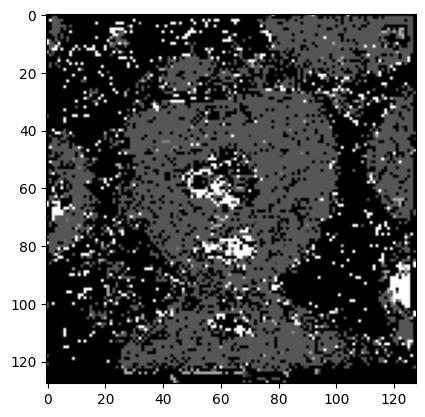

In [60]:
################################################################
#Start segmenting future images

#Load model.... 
loaded_model = pickle.load(open(filename, 'rb'))

#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('test_images/A4.png', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)

X_test_feature = new_model.predict(test_img)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])
prediction = loaded_model.predict(X_test_feature)

#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')
plt.show()


In [61]:
plt.imsave('test_images/A4_predicted_xgboost.png', prediction_image, cmap='gray')

In [62]:
#########################################################
#Check accuracy and IoU
######################################################
#READ EXTERNAL IMAGE...
validation_img = cv2.imread('test_images/A4.png', cv2.IMREAD_COLOR)       
validation_img = cv2.resize(validation_img, (SIZE_Y, SIZE_X))
validation_img = cv2.cvtColor(validation_img, cv2.COLOR_RGB2BGR)
validation_img = np.expand_dims(validation_img, axis=0)

X_validation_feature = new_model.predict(validation_img)
X_validation_feature = X_validation_feature.reshape(-1, X_validation_feature.shape[3])
prediction_validation = loaded_model.predict(X_validation_feature)

#Load ground truth image (Mask)
truth = cv2.imread('test_images/A4_predicted_xgboost.png', 0).reshape(-1)

1/1 [==============================] - 0s 23ms/step


In [63]:
##########################################
#Pixel accuracy - not a good metric for semantic segmentation
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(truth, prediction_validation))

##############################################

#IOU for each class is..
# IOU = true_positive / (true_positive + false_positive + false_negative).

#Using built in keras function
from keras.metrics import MeanIoU
num_classes = 4
IOU_keras = MeanIoU(num_classes=num_classes)  
IOU_keras.update_state(truth, prediction_validation)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(num_classes, num_classes)
print(values)
class1_IoU = values[1,1]/(values[1,1] + values[1,2] + values[1,3] + values[1,4] + values[2,1]+ values[3,1]+ values[4,1])
class2_IoU = values[2,2]/(values[2,2] + values[2,1] + values[2,1] + values[2,3] + values[1,2]+ values[3,2]+ values[4,2])
class3_IoU = values[3,3]/(values[3,3] + values[3,1] + values[3,2] + values[3,4] + values[1,3]+ values[2,3]+ values[4,3])
class4_IoU = values[4,4]/(values[4,4] + values[4,1] + values[4,2] + values[4,3] + values[1,4]+ values[2,4]+ values[3,4])

print("IoU Class 1 =", class1_IoU)
print("IoU Class 2 =", class2_IoU)
print("IoU Class 3 =", class3_IoU)
print("IoU Class 4 =", class4_IoU)

# Change hyperparameters to fine tune the model and verify IoU.


Accuracy =  0.53228759765625


InvalidArgumentError: `labels` out of bound
Condition x < y did not hold.
First 3 elements of x:
[0 0 0]
First 1 elements of y:
[4]